Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---

In [29]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Define ML problems
- Choose a target to predict, and check its distribution
- Avoid leakage of information from test to train or from target to features
- Choose an appropriate evaluation metric


# Wrangle Data

## Import Data

In [30]:
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv', 
                 parse_dates=['Date'],
                 index_col='Date')

## EDA

Issues:

- Lot `NaN` values (Antony)
- Sparse features (Ben)
- Columns with `'x'` instead of `1` (Jacob)
- High cardinality columns

In [31]:
def wrangle(df):
    df = df.copy()
    
    # We know that we can't use rows where there's no target
    df = df.dropna(subset=['overall'])
    
    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int)
    
    # Drop the old target
    df.drop(columns=['overall', 'Rec'], inplace=True)
    
    # OHE wonky coluomns
    ohe_cats = df.select_dtypes('object').nunique()
    ohe_cols = [col for col in ohe_cats.index if ohe_cats[col] <= 2]
    for col in ohe_cols:
        df[col] = df[col].str.lower().apply(lambda x: 1 if x=='x' else 0)
    
    # Identify and drop high-cardinality columns
    threshold = 10
    unique_cats = df.select_dtypes('object').nunique()
    high_card_cols = [col for col in unique_cats.index if unique_cats[col] > threshold]
    df = df.drop(high_card_cols, axis=1)
    
    # Dropping columns with high number of NaN values
    df = df.dropna(axis=1, thresh=400)
    
    return df

In [32]:
df = wrangle(df)

# Split Data

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cost           414 non-null    float64
 1   Hunger         418 non-null    float64
 2   Tortilla       421 non-null    float64
 3   Temp           401 non-null    float64
 4   Meat           407 non-null    float64
 5   Fillings       418 non-null    float64
 6   Meat:filling   412 non-null    float64
 7   Uniformity     419 non-null    float64
 8   Synergy        419 non-null    float64
 9   Wrap           418 non-null    float64
 10  Unreliable     421 non-null    int64  
 11  NonSD          421 non-null    int64  
 12  Beef           421 non-null    int64  
 13  Pico           421 non-null    int64  
 14  Guac           421 non-null    int64  
 15  Cheese         421 non-null    int64  
 16  Fries          421 non-null    int64  
 17  Sour cream     421 non-null    int6

Split target vector from feature matrix

In [35]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

Split dataset into training, validation, and test sets

In [44]:
training_set = df[df.index.year < 2017]
validation_set = df[df.index.year == 2017]
testing_set = df[df.index.year > 2017]

train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

validation_mask = X.index.year == 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]

test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

In [45]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

298
85
38


# Establish Baseline

In [46]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# Build Model

- Model 1: Random Forest
- Model 2: Logistic Regression

In [59]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt

In [53]:
# Model 1: Random Forest
model_rf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier()
)

model_rf.fit(X_train, y_train);

In [56]:
# Model 2: Logistic Regresion
model_lr = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

# Check Metrics

Accuracy

In [57]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8588235294117647


In [58]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.912751677852349
Validation Accuracy (LOGR): 0.788235294117647


Classification Report

In [60]:
# On validation data only
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.81      0.89      0.85        38

    accuracy                           0.86        85
   macro avg       0.86      0.86      0.86        85
weighted avg       0.86      0.86      0.86        85



In [61]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.70      0.79        47
           1       0.71      0.89      0.79        38

    accuracy                           0.79        85
   macro avg       0.80      0.80      0.79        85
weighted avg       0.81      0.79      0.79        85



ROC Curve

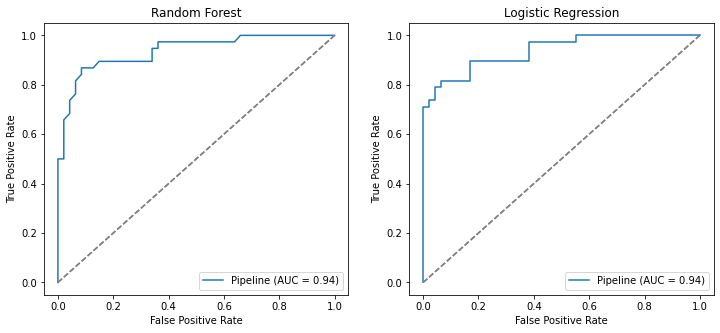

In [70]:
# How to plot side-by-side figures
## Create subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

## Plot ROC curves
plot_roc_curve(model_rf, X_val, y_val, ax=ax1)
plot_roc_curve(model_lr, X_val, y_val, ax=ax2)

## Plot center lines
ax1.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax2.plot([(0,0), (1,1)], color='grey', linestyle='--')

## Set titles
ax1.set_title('Random Forest')
ax2.set_title('Logistic Regression')

plt.show()

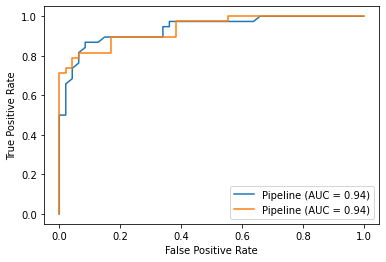

In [71]:
rf = plot_roc_curve(model_rf, X_val, y_val)
lr = plot_roc_curve(model_lr, X_val, y_val, ax=rf.ax_)
plt.show();